In [1]:
import sys
sys.path.append('./code')
sys.path.append('./data')

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from clustering import *
from sklearn.metrics import * 

from sklearn.metrics import ConfusionMatrixDisplay

np.random.seed(1)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.linewidth'] = 1.25

#modified from Kausik et al's code

In [2]:
nGenres=100
genres = pd.read_csv('data/Lastfm-ArtistTags2007/tags.txt', header=None)[0].values[:nGenres]
genres = pd.DataFrame([genre.split()[0] for genre in genres], 
             index = [' '.join(genre.split()[1:]) for genre in genres],
            columns = ['count'])
genres.head()

,count
rock,440854
seen live,343901
indie,277747
alternative,245259
metal,184491


In [3]:
users = pd.read_csv("data/lastfm-dataset-1K/userid-profile.tsv", sep="\t")
users.head()

,#id,gender,age,country,registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,NaN,NaN,"Apr 26, 2006"
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006"


In [4]:
lastfm = pd.read_csv("data/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv", sep="\t", 
           header=None, on_bad_lines='skip')
lastfm.columns = ['userid', 'timestamp', 'artistid', 'artistname', 'trackid', 'trackname']
nTopUsers=10
topusers = lastfm.groupby('userid').size().sort_values()[-nTopUsers:]
lastfm = lastfm[[user in topusers for user in lastfm['userid']]]
lastfm.timestamp = pd.to_datetime(lastfm['timestamp'])

In [5]:
tags = pd.read_table('data/Lastfm-ArtistTags2007/ArtistTags.dat', sep="<sep>", header=None, on_bad_lines='skip')
tags.columns = ['artistid', 'artistname', 'tagname', 'rawtagcount']
tags = tags[[tag in genres.index for tag in tags['tagname']]]
# there are multiple tags/genres assigned to each artist.
#  for simplicity, pick the tag/genre most associated with each artist
#  by ranking by raw tag count and picking the first
tags = tags[tags.groupby(['artistid', 'artistname'])['rawtagcount'].rank(method='first', ascending=False) <= 1]

/tmp/cemiles/31573676/ipykernel_2509034/2105939917.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tags = pd.read_table('data/Lastfm-ArtistTags2007/ArtistTags.dat', sep="<sep>", header=None, on_bad_lines='skip')


In [6]:
dataset = lastfm.merge(tags, on='artistid').sort_values(['userid', 'timestamp'])[['userid', 'timestamp', 'tagname']].reset_index()
# assigning numbers to genres. doing so by ranking genres by how popular they are
tagdict = dict(zip(genres.index.values, np.arange(len(genres))))
dataset['tagnum'] = dataset['tagname'].replace(tagdict)
# for some reason, gupta et al only consider the transitions that change genre
#  we do so here
keeps = (dataset.tagname != dataset.tagname.shift()) * (dataset.userid == dataset.userid.shift())
keeps[0] = True
dataset = dataset[keeps]

/opt/apps/anaconda/2022.05/lib/python3.9/site-packages/pandas/core/computation/expressions.py:214: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  warnings.warn(


In [7]:
nStates = len(genres)
nActions = 1
K = len(topusers)
horizon = 250 # length of trajectories 
N = int(75*horizon) # fix this so 750 total trajectories like previous papers
numTrajPerK = int(N/horizon)
nTraj = numTrajPerK * K

In [8]:
numTrajPerK

75

In [9]:
#gupta et al only keep first 3000 transitions
#building array of one hots


#shuffling dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset = dataset.sort_values(by='timestamp')    

states = np.array([dataset[dataset.userid == user].tagnum.values[:N] 
          for user in topusers.index.sort_values()])

#nextstates = np.array([dataset[dataset.userid == user].tagnum.values[1:N+1] 
#          for user in topusers.index.sort_values()])
#onehots = np.array([np.eye(nStates)[dataset[dataset.userid == user].tagnum.values][:N] 
#          for user in topusers.index.sort_values()])
#onehotsp = np.array([np.eye(nStates)[dataset[dataset.userid == user].tagnum.values][1:N+1] 
#          for user in topusers.index.sort_values()])

#splitting into trajectories of length horizon
states = np.array(np.split(states, numTrajPerK, axis=1)).transpose(1,0,2)
#nextstates = np.array(np.split(nextstates, numTrajPerK, axis=1)).transpose(1,0,2)
#onehots = np.array(np.split(onehots, numTrajPerK, axis=1)).transpose(1,0,2,3)
#onehotsp = np.array(np.split(onehotsp, numTrajPerK, axis=1)).transpose(1,0,2,3)

print('shape of states before concat first axis:', states.shape)
#print('shape of onehots before concat first axis:', onehots.shape)
#why concatenate? want 0,..,0,1...,1,...,9...,9
labels = np.concatenate([np.ones(numTrajPerK)*k for k in range(K)])
states = np.concatenate(states)
#nextstates = np.concatenate(nextstates)
#onehots = np.concatenate(onehots)
#onehotsp = np.concatenate(onehotsp)
print('shape of states after concat first axis:', states.shape)
#print('shape of onehots after concat first axis:', onehots.shape)

#inds = np.arange(len(labels)) # Kausik shuffles but we do not. Why temporally shuffle temporal data?
#np.random.shuffle(inds)
#labels = labels[inds]
#states = states[inds]
#onehots = onehots[inds]
#onehotsp = onehotsp[inds]

shape of states before concat first axis: (10, 75, 250)
shape of states after concat first axis: (750, 250)


In [10]:
nEM = 7500
nClustMax=10

Xt=states
nStates=nGenres

#nTrials = 10
best_err = 1.0

predictLabelsC_best = []

#for s in range(nTrials):

zHat, muHat, qHat, pHat, steps, logL = doVEMmultiPar(Xt, nClustMax, nStates, nEM=nEM)

trueLabels = labels.astype('int64')
best_assignment, zHat_c, qHat_c, muHat_c, pHat_c = find_best_clustermatch(trueLabels.T, zHat, muHat, qHat, pHat)  # uses HUNGARIAN ALGORITHM to assign best permutation
        
predictLabels = zHat_c.argmax(axis=1)
trueLabelsC = trueLabels
predictLabelsC = predictLabels
error = 1.0-sum(trueLabels==predictLabels)/len(predictLabels)
   # if error<best_err:
predictLabelsC_best = predictLabelsC
best_err=error

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed: 23.3min finished


In [11]:
best_err

0.348

In [12]:
#
#adj_rand = adjusted_rand_score(trueLabels,predictLabels)
#print(adj_rand)

In [13]:
#rand = rand_score(trueLabels,predictLabels)
#print(rand)

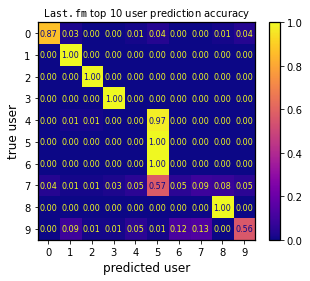

In [14]:
trueLabelsC = trueLabels
predictLabelsC = predictLabels
fig =plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

disp=ConfusionMatrixDisplay.from_predictions(trueLabelsC,predictLabelsC_best,normalize='true',values_format='.2f',cmap="plasma",ax=ax,text_kw={"fontsize":8})#,cmap=plt.cm.Blues)
disp.ax_.set_title('${\\tt Last.fm}$ top 10 user prediction accuracy',fontsize=10)
disp.ax_.set_xlabel("predicted user",fontsize=12)
disp.ax_.set_ylabel("true user",fontsize=12)

plt.savefig('figs/lastfm_confusion.pdf',format='pdf')

In [15]:
with open('temp/lastfm10_confusion.npy', 'wb') as f:
    np.save(f,trueLabelsC)
    np.save(f,predictLabelsC)